In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import glob
from saturation.utils import *

In [128]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

In [129]:
base_path = "/data/saturation/thesis_run_20240717_rmult_erat_tests"
configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [130]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [131]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)

    ax.plot(data[x_var], data[y_var], color='b')

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig

## Plots of individual simulations vs N_tot, shallow slope

In [132]:
configs_pdf

,erat,mrp,rmult,simulation_id,slope
0,1.0,0.50,1.0,1,-4.0
1,1.0,0.50,1.0,2,-3.5
2,1.0,0.50,3.0,10,-4.0
3,3.0,0.50,1.0,8,-4.0
4,1.0,0.25,1.0,4,-4.0
5,1.0,0.75,1.0,5,-4.0
6,1.0,0.50,2.0,9,-4.0


In [120]:
# Looking for a simulation with shallow slope
configs_pdf[configs_pdf.slope.between(-1.1, -1.0)]

,erat,mrp,rmult,simulation_id,slope


In [144]:
# Choosing simulation 1
simulation_id = 4
configs_pdf[configs_pdf.simulation_id == simulation_id]

,erat,mrp,rmult,simulation_id,slope
4,1.0,0.25,1.0,4,-4.0


In [134]:
# Full configuration
configs_dict[simulation_id]

{'erat': 1.0,
 'max_crater_radius': 500,
 'min_crater_radius': 3,
 'mrp': 0.5,
 'random_seed': 123,
 'rmult': 1.0,
 'simulation_name': '1.000_0.500_1.000_-4.000',
 'slope': -4.0,
 'spatial_hash_cell_size': 5,
 'stop_condition': {'ntot': 10000000, 'name': 'ntot'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [135]:
df = data.where(F.col("simulation_id") == simulation_id).orderBy("ntot").toPandas()

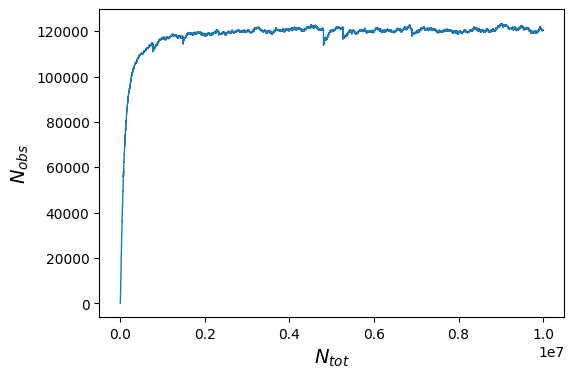

In [136]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    ls="-"
)
ax1.set_ylabel("$N_{obs}$", fontsize=14)
ax1.set_xlabel("$N_{tot}$", fontsize=14)

plt.show()

In [145]:
target_ntots = [50000, 500000, 1000000, 10000000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [146]:
# states[500].radius.mean()

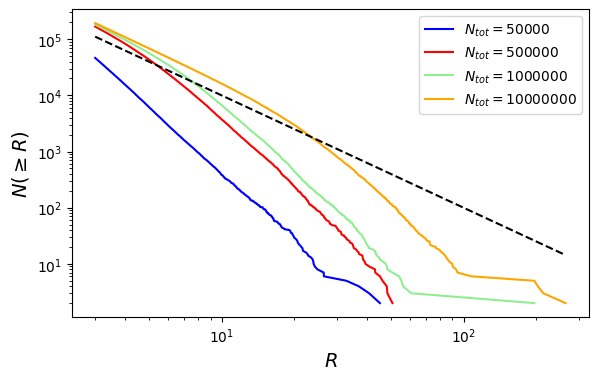

In [147]:
fig = plot_csfds_for_multiple_ntot(states, reference_slope=2.0, reference_intercept=1e6)
fig.savefig("figures/shallow_slope_csfds.png", bbox_inches="tight")
plt.show()

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, 4000])
ax.set_ylim([0, 4000])

s = states[1000]

ax.scatter(s.x - 500, s.y - 500, s=0.5)

In [24]:
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[0.37]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_ad.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[1.87]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_za.png", bbox_inches="tight")

In [25]:
font_size = 16

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)

ax.plot(df.ntot, df.nobs, color='b')
ax.axhline(625, color="r", linestyle="--")
ax.set_xlabel("$N_{tot}$", fontsize=font_size)
ax.set_ylabel("$N_{obs}$", fontsize=font_size)

fig.savefig("figures/shallow_slope_ntot_nobs.png", bbox_inches="tight")
fig.show()

## Plots of individual simulations vs N_tot, steep slope

In [44]:
# Looking for a simulation with steep slope
configs_pdf[configs_pdf.slope.between(-3.0, -2.9)]

,erat,mrp,rmult,simulation_id,slope
11,11.574684,0.646657,1.895924,960,-2.941692
39,5.249486,0.280293,1.663895,57,-2.980598
123,12.220241,0.505943,1.262862,441,-2.969967
127,13.884488,0.517125,1.265081,758,-2.996001
203,4.714725,0.388123,1.299906,727,-2.936750
244,5.117249,0.501526,1.887954,777,-2.935801
320,4.907633,0.421339,1.811545,428,-2.953448
425,3.170657,0.508407,1.628720,97,-2.931013
432,9.415526,0.420162,1.536459,862,-2.912369
452,5.958676,0.386930,1.429712,763,-2.988105


In [45]:
# Choosing simulation 97
simulation_id = 97
configs_pdf[configs_pdf.simulation_id == simulation_id]

,erat,mrp,rmult,simulation_id,slope
425,3.170657,0.508407,1.62872,97,-2.931013


In [46]:
# Full configuration
configs_dict[simulation_id]

{'erat': 3.1706566712753723,
 'max_crater_radius': 500,
 'min_crater_radius': 5,
 'mrp': 0.5084073135420222,
 'random_seed': 1630885,
 'rmult': 1.6287202638243232,
 'simulation_name': '3.171_0.508_1.629_-2.931',
 'slope': -2.9310133950102544,
 'spatial_hash_cell_size': 10,
 'stop_condition': {'information_remaining_threshold': 0.05,
  'name': 'information_remaining'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [47]:
df = data.where(F.col("simulation_id") == simulation_id).toPandas()

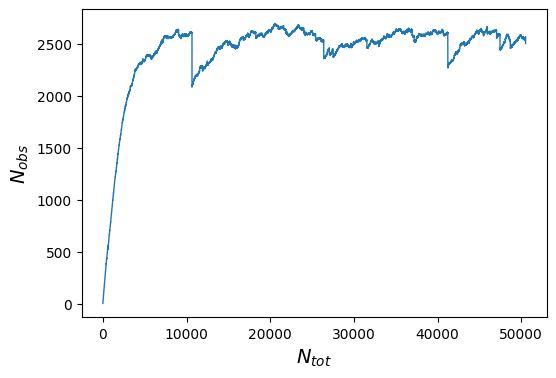

In [48]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    ls="-"
)
ax1.set_ylabel("$N_{obs}$", fontsize=14)
ax1.set_xlabel("$N_{tot}$", fontsize=14)

plt.show()

In [49]:
target_ntots = [100, 300, 20000, 40000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [50]:
states[40000].radius.mean()

np.float32(9.726151)

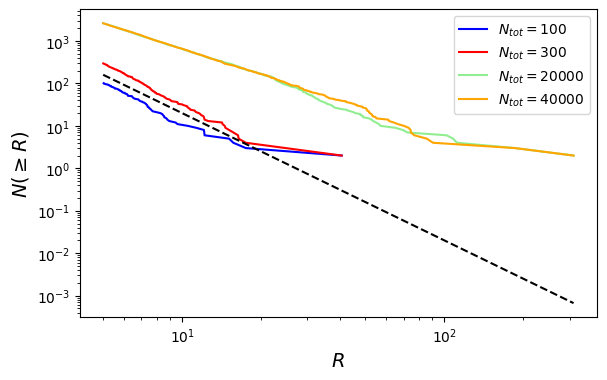

In [52]:
fig = plot_csfds_for_multiple_ntot(states, reference_slope=3, reference_intercept=2e4)
fig.savefig("figures/steep_slope_csfds.png", bbox_inches="tight")
plt.show()

In [40]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, 4000])
ax.set_ylim([0, 4000])

s = states[40000]

ax.scatter(s.x - 500, s.y - 500, s=0.5)

In [41]:
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[0.125]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_ad.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[1.55]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_za.png", bbox_inches="tight")

In [42]:
font_size = 16

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)

ax.plot(df.ntot, df.nobs, color='b')
ax.axhline(4100, color="r", linestyle="--")
ax.set_xlabel("$N_{tot}$", fontsize=font_size)
ax.set_ylabel("$N_{obs}$", fontsize=font_size)

fig.savefig("figures/steep_slope_ntot_nobs.png", bbox_inches="tight")
fig.show()

## Plots of single simulations, high destruction, slope = -2.5

In [43]:
# Looking for a simulation with high destruction
configs_pdf["destruction"] = configs_pdf.effective_radius_multiplier * configs_pdf.min_rim_percentage * configs_pdf.r_stat_multiplier
configs_pdf[configs_pdf.slope.between(2.5, 2.6)].sort_values("destruction")

In [44]:
# Choosing simulation 43
simulation_id = 43
configs_pdf[configs_pdf.simulation_id == simulation_id]

In [45]:
# Full configuration
configs_dict[simulation_id]

In [46]:
df = data.where(F.col("simulation_id") == simulation_id).toPandas()

In [47]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    ls="-"
)
ax1.set_ylabel("$N_{obs}$", fontsize=14)
ax1.set_xlabel("$N_{tot}$", fontsize=14)

plt.show()

In [52]:
target_ntots = [2000, 4500, 10000, 15000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [53]:
fig = plot_csfds_for_multiple_n_tot(states, reference_slope=2.51, reference_intercept=2e5)
fig.savefig("figures/high_destruction_csfds.png", bbox_inches="tight")
plt.show()

In [50]:
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[0.078]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_ad.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[1.72]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_za.png", bbox_inches="tight")

In [51]:
font_size = 16

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)

ax.plot(df.ntot, df.nobs, color='b')
ax.axhline(1800, color="r", linestyle="--")
ax.set_xlabel("$N_{tot}$", fontsize=font_size)
ax.set_ylabel("$N_{obs}$", fontsize=font_size)

fig.savefig("figures/high_destruction_ntot_nobs.png", bbox_inches="tight")
fig.show()

## Plots of single simulations, low destruction, slope = -2.5

In [54]:
# Looking for a simulation with low destruction
configs_pdf["destruction"] = configs_pdf.effective_radius_multiplier * configs_pdf.min_rim_percentage * configs_pdf.r_stat_multiplier
configs_pdf[configs_pdf.slope.between(2.5, 2.6)].sort_values("destruction")

In [55]:
# Choosing simulation 1693
simulation_id = 1693
configs_pdf[configs_pdf.simulation_id == simulation_id]

In [56]:
# Full configuration
configs_dict[simulation_id]

In [57]:
df = data.where(F.col("simulation_id") == simulation_id).toPandas()

In [58]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    ls="-"
)
ax1.set_ylabel("$N_{obs}$", fontsize=14)
ax1.set_xlabel("$N_{tot}$", fontsize=14)

plt.show()

In [64]:
target_ntots = [2000, 30000, 50000, 140000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [65]:
fig = plot_csfds_for_multiple_n_tot(states, reference_slope=2.50, reference_intercept=5e6)
fig.savefig("figures/low_destruction_csfds.png", bbox_inches="tight")
plt.show()

In [66]:
df_copy = df.copy()
df_copy["ntot"] = df_copy.ntot / 1000

In [67]:
fig = plot_metric(
    df_copy,
    "ntot",
    "$N_{tot}$ (thousands)",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[0.58]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_ad.png", bbox_inches="tight")

fig = plot_metric(
    df_copy,
    "ntot",
    "$N_{tot}$ (thousands)",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[1.24]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df_copy,
    "ntot",
    "$N_{tot}$ (thousands)",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df_copy,
    "ntot",
    "$N_{tot}$ (thousands)",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_za.png", bbox_inches="tight")

In [68]:
font_size = 16

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)

ax.plot(df.ntot, df.nobs, color='b')
ax.axhline(16000, color="r", linestyle="--")
ax.set_xlabel("$N_{tot}$", fontsize=font_size)
ax.set_ylabel("$N_{obs}$", fontsize=font_size)

fig.savefig("figures/low_destruction_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [69]:
# Calculates the mean of a truncated Pareto distribution
def calc_mean(alpha: float, x_min: float, x_max: float) -> float:
    return (alpha * x_max**(1 - alpha) * x_min**(alpha) - alpha * x_min) / ((1 - alpha) * (1 - (x_min/x_max)**alpha))

In [102]:
np.log10(calc_mean(2.0, 5 * 1.5, 1000))

In [101]:
np.log10(calc_mean(2.5, 5 * 1.5, 1000))

In [103]:
np.log10(calc_mean(1.2, 5 * 1.5, 1000))

In [94]:
calc_mean(2.93, 5, 1000)

In [95]:
calc_mean(2.5, 5, 1000)

In [92]:
10**1.87

In [93]:
10**1.55